In [11]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 16

train_data_dir = './fer2013/train'
validation_data_dir = './fer2013/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #8: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation_37 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_38 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 32)       

In [13]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("emotion_little_vgg_3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 3589
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
1794/1794 [==============================] - ETA: 0s - loss: 2.0539 - accuracy: 0.1972
Epoch 00001: val_loss improved from inf to 1.79897, saving model to emotion_little_vgg_3.h5
1794/1794 [==============================] - 500s 278ms/step - loss: 2.0539 - accuracy: 0.1972 - val_loss: 1.7990 - val_accuracy: 0.2439
Epoch 2/10
1794/1794 [==============================] - ETA: 0s - loss: 1.8110 - accuracy: 0.2415
Epoch 00002: val_loss did not improve from 1.79897
1794/1794 [==============================] - 454s 253ms/step - loss: 1.8110 - accuracy: 0.2415 - val_loss: 1.8000 - val_accuracy: 0.2391
Epoch 3/10
1794/1794 [==============================] - ETA: 0s - loss: 1.7980 - accuracy: 0.2471
Epoch 00003: val_loss improved from 1.79897 to 1.78233, saving model to emotion_little_vgg_3.h5
1794/1794 [==============================] - 454s 253ms/step - loss: 1.7980 - accuracy: 0.2471 - val_loss: 1.7823 - val_accuracy: 0.2765
Epoch 4/10
1794/1794 [==============================] - 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

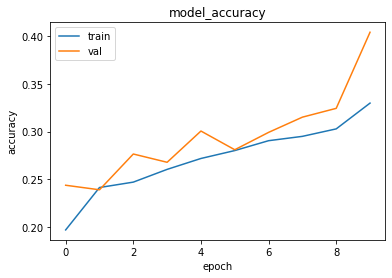

In [15]:
losses = history.history['accuracy']
val_losses = history.history['val_accuracy']
plt.plot(losses)
plt.plot(val_losses)
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='best')

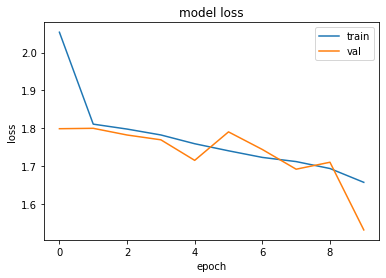

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np

In [18]:
y_pred = model.predict(validation_generator)
y_pred_true = np.argmax(y_pred,axis=1)
label_map = (train_generator.class_indices)

In [20]:
print(classification_report(validation_generator.classes,y_pred_true,target_names=label_map.keys()))

              precision    recall  f1-score   support

       Angry       0.19      0.01      0.01       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.25      0.03      0.06       528
       Happy       0.51      0.79      0.62       879
     Neutral       0.21      0.15      0.17       626
         Sad       0.31      0.59      0.40       594
    Surprise       0.52      0.70      0.60       416

    accuracy                           0.40      3589
   macro avg       0.28      0.32      0.27      3589
weighted avg       0.34      0.40      0.33      3589



In [21]:

df_cm = pd.DataFrame(confusion_matrix(validation_generator.classes,y_pred_true),label_map.keys(),label_map.keys())

Text(195.0, 0.5, 'label (ground truth)')

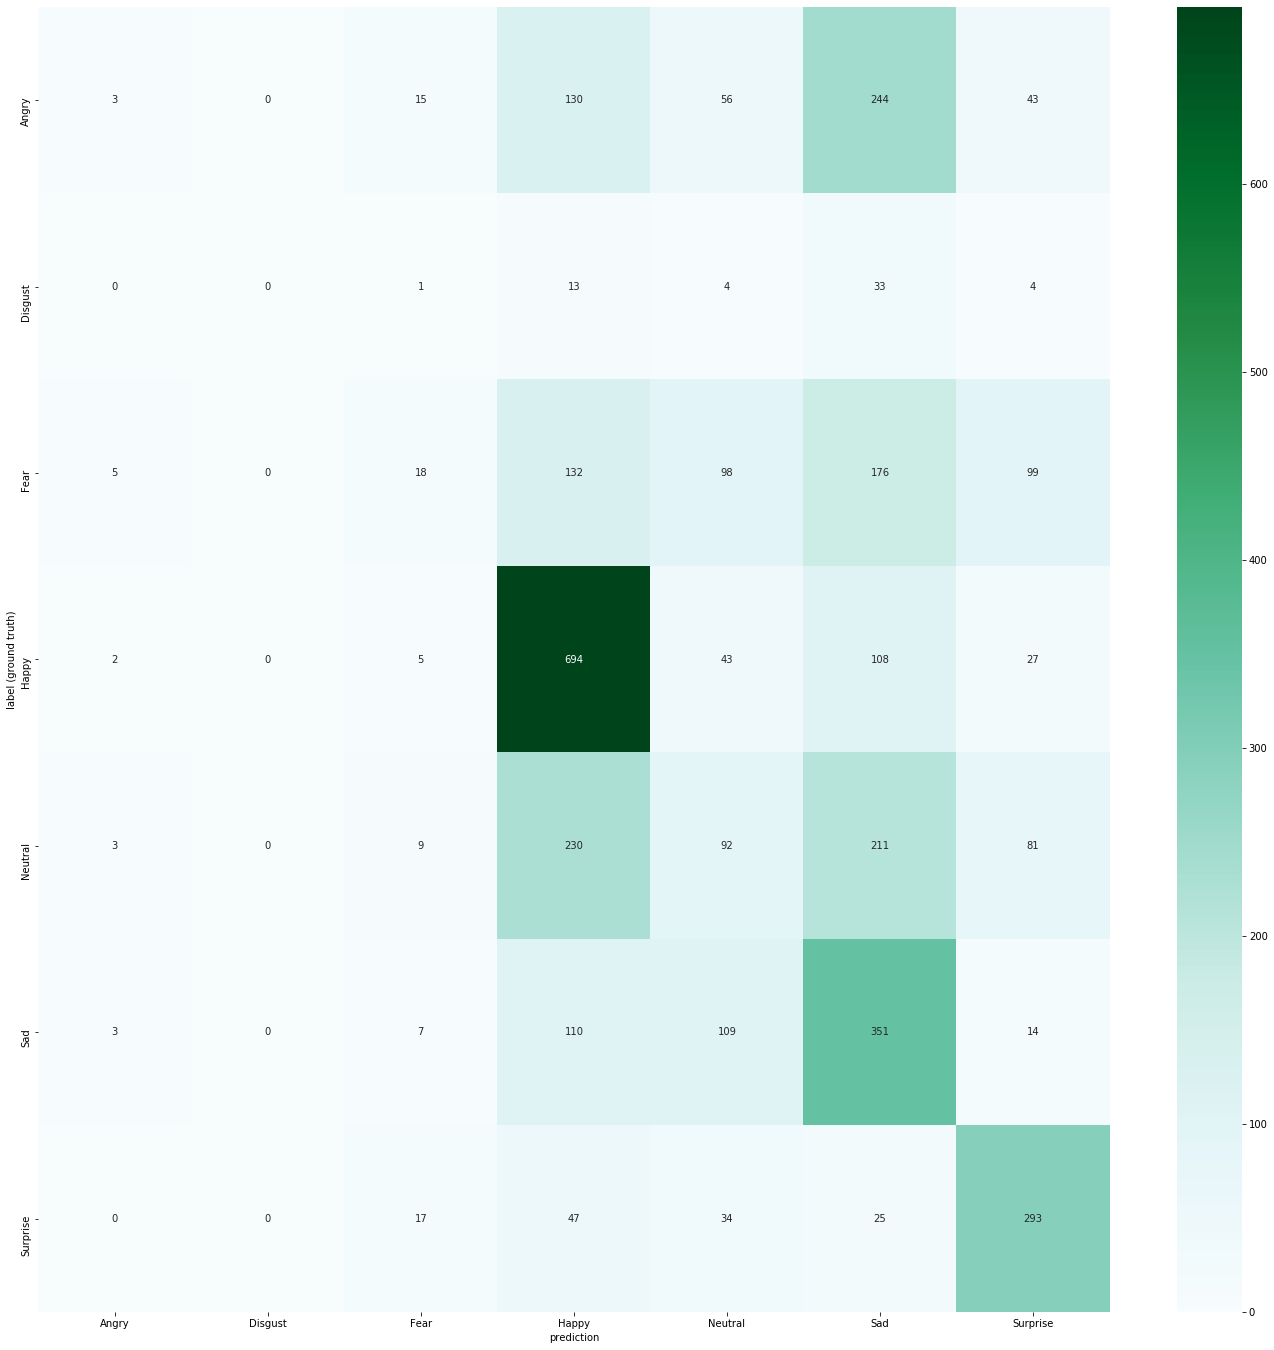

In [22]:
#print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes,y_pred))
plt.figure(figsize=(24,24))
sns.heatmap(df_cm,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")